# Introduction

Integrate in time the vorticity equation.

Run the simple code first.

1. Then change to $Re=10$, $nx=11$, $dt=0.035$, $dpic=0.025$ and $tfinal=0.525$. The plot of the streamfunction should show the numerical instability. Decreasing $dt$ to 0.03 nearly stabilises the result at this $tfinal$, while $dt=0.025$ works to $tfinal=3.0$. This value of $dt$ is the marginal value, but that is for large grids, and small grids are slightly more stable. Best to work at $dt=0.2*Re*h*h$

1. The code first calculates the boundary conditions to first-order, and then extrapolates these results to apply the conditions to second-order. Use this second-order code. Change to  $Re=10$, $nx=11$, $dpic=0.1$ and $tfinal=1.0$ and $dt=0.02$. Find the value of $\omega(x=0.5,y=0.5,t=1.0)$. Now decrease $dt$ to 0.01, 0.005, 0.0025 and 0.001. Then with $nx=15$ try $dt$ = 0.01 (largest stable value), 0.005, 0.0025 and 0.001. Finally with $nx=21$ try $dt=$ 0.005 (largest stable value), 0.0025 and 0.001. Plot these results for $\psi(x=0.5,y=0.5,t=1.0)$ as a function of $dt$. **You could experiment by deleting the lines of the code that apply the boundary conditions at second-order.**

1. Now set $tfinal=3.0$, $dpic=0.1$ and $dt=0.2*Re*h*h$ and obtain $\omega(x=0.5,y=0.5,t)$ to find how long it takes the vorticity to attain a steady value within 4 significant figures. Compare your plots for the steady state of the streamfunction and the vorticity.

1. Gather results for different spatial resolutions $nx$ for the steady horizontal velocity $u$ at the mid-section $x=0.5$, and plot on top of one another.

1. The code calculates the force on the top plate to second-order accuracy. Find the steady force for different spatial resolutions, $nx=11$, 15, 21, 29 and 41. Plot the force as a function of the grid size $h$.

1. Change the top slip boundary condition from $u=\sin^2\pi x$ to $u=1$, i.e change

    $$
    w(i,nx)= -(sin(pi*(i-1)*h)*sin(pi*(i-1)*h)... 
    $$

    to

    $$
    w(i,nx) = -1...
    $$

    Find the force on the top plate for various spatial resolutions, say $nx= 10$, 14, 20, 28 and 40. **Show that the force diverges as the resolution increases as $F = 4.32\ln(1/h) - 3.75$.**

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg

from collections import defaultdict

# Sparse solver

In [2]:
def construct_laplacian_kernel_matrix(N, h):
    # Construct the matrix that defines the linear system

    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)
    
    return rows, cols, values

In [3]:
# Fast Poisson solver that exploits the sparsity of the problem. Assumes psi=0 on the boundaries
def sparse_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = scipy.sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    # Solve the sparse linear system
    psi = scipy.sparse.linalg.spsolve(
        A=kernel_matrix_sparse,
        b=-w[1:-1, 1:-1].flatten().reshape((N ** 2, 1))
    )
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


In [4]:
# Incorporates both the Poisson problem and time-stepping for the vorticity
def solve_using_timestepping(N, Re, tfinal, dt=None, print_every=0.0):
    nx = N + 1 # i.e. N = 10
    ny = nx # square domain
    h = 1 / N # h = dx (=dy) = 1 / N; x-size is 1, y-size is ny/nx
    
    w = np.zeros(shape=(nx, ny)) # vorticity
    psi = np.zeros(shape=(nx, ny)) # streamfunction
    dw_dt = np.zeros(shape=(nx, ny)) # dw/dt    
    
    if dt is None:
        dt = np.round(0.2 * Re * h ** 2, 8) # 0.8 * marginal value
    
    omega_mid = []
    
    t = 0
    while t < tfinal:
        # Start by solving the Poisson problem
        psi = sparse_solver(w)

        
        # Now time-step vorticity

        
        # First calculate BCs to 1st order

        # y = 0. Note U_wall = 0
        w[1:nx - 1, 0] = -((psi[1:nx - 1, 1] - psi[1:nx - 1, 0]) / h - 0) / (0.5 * h)
        # y = 1. Note U_wall is given here
        w[1:nx - 1, ny - 1] = -(
            np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2 -
            (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
        ) / (0.5 * h)
        
        # x = 0. Note U_wall = 0
        w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
        # x = 1. Note U_wall = 0
        w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)

        
        # Compute the 2nd order correction to the BCs
        
        # y = 0
        w[1:nx - 1, 0] = (4 * w[1:nx - 1, 0] - w[1:nx - 1, 1]) / 3
        # y = 1
        w[1:nx - 1, ny - 1] = (4 * w[1:nx - 1, ny - 1] - w[1:nx - 1, ny - 2]) / 3
        
        # x = 0
        w[0, 1:ny - 1] = (4 * w[0, 1:ny - 1] - w[1, 1:ny - 1]) / 3

        # x = 1
        w[nx - 1, 1:ny - 1] =(4 * w[nx - 1, 1:ny - 1] - w[nx - 2, 1:ny - 1]) / 3

        # We can now find dw/dt
        dw_dt[1:nx - 1, 1:ny - 1] = (
            -(
                (psi[1:nx - 1, 2:ny] - psi[1:nx - 1, 0:ny - 2]) *
                (w[2:nx, 1:ny - 1] - w[0:nx - 2, 1:ny - 1])
            ) / (4 * h ** 2) + 
            (
                (psi[2:nx, 1:ny - 1] - psi[0:nx - 2, 1:ny - 1]) *
                (w[1:nx - 1, 2:ny] - w[1:nx - 1, 0:ny - 2])
            ) / (4 * h ** 2) + 
            (
                w[2:nx, 1:ny - 1] + w[0:nx - 2, 1:ny - 1] +
                w[1:nx - 1, 2:ny] + w[1:nx - 1, 0:ny - 2] -
                4 * w[1:nx - 1 , 1:ny - 1]
            ) / (Re * h ** 2)
        )

        # Finally, update w
        w[1:nx - 1, 1:ny - 1] = w[1:nx - 1, 1:ny - 1] + dw_dt[1:nx - 1, 1:ny - 1] * dt
        
        # One pass done, increment time
        t = np.round(t + dt, 8)
        
        # Print
        if print_every > 0:
            if 0 <= np.round(t % print_every, 8) < dt:
                print(f"t={t:.5f}; w(0.5, 0.5)={w[nx // 2, ny // 2]}")
        
        omega_mid.append(w[nx // 2, ny // 2])
    
    return w, psi, np.array(omega_mid)


In [5]:
solve = solve_using_timestepping

In [6]:
# # First calculate BCs to 1st order

# # y = 0. Note U_wall = 0
# w[1:-1, 0] = -((psi[1:-1, 1] - psi[1:-1, 0]) / h - 0) / (0.5 * h)
# # y = 1. Note U_wall is given here
# w[1:nx - 1, ny - 1] = -(
#     np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2 -
#     (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
# ) / (0.5 * h)

# # x = 0. Note U_wall = 0
# w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
# # x = 1. Note U_wall = 0
# w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)


# # Compute the 2nd order correction to the BCs

# # y = 0
# w[1:-1, 0] = (4 * w[1:-1, 0] - w[1:-1, 1]) / 3
# # y = 1
# w[1:-1, -1] = (4 * w[1:-1, -1] - w[1:-1, -2]) / 3

# # x = 0
# w[0, 1:-1] = (4 * w[0, 1:-1] - w[1, 1:-1]) / 3

# # x = 1
# w[-1, 1:-1] =(4 * w[-1, 1:-1] - w[-2, 1:-1]) / 3

# Newton-Raphson solver

Tries to solve directly for the steady state.

In [7]:
# Given the vorticity, solve the Poisson eqn. to find the streamfunction
def get_standard_basis_vector(size, i):
    vec = np.zeros((size, 1))
    vec[i] = 1.0
    
    return vec


def get_jacobian(f, x, N, h, Re):
    f_evaluated = f(x=x, N=N, h=h, Re=Re)
    
    # Jacobian is sparse
    return scipy.sparse.csr_matrix(
        np.hstack([(
            f(x=x + h * get_standard_basis_vector(size=x.shape[0], i=i), N=N, h=h, Re=Re) -
            f_evaluated
        ) for i in range(x.shape[0])])
    )


def reconstruct_w(w_tmp, N):
    w = np.zeros((N+1, N+1))
    
    w[:1, 1:-1] = w_tmp[0*(N-1):1*(N-1)].T
    w[-1:, 1:-1] = w_tmp[1*(N-1):2*(N-1)].T
    w[1:-1, :1] = w_tmp[2*(N-1):3*(N-1)]
    w[1:-1, -1:] = w_tmp[3*(N-1):4*(N-1)]
    w[1:-1, 1:-1] = w_tmp[4*(N-1):].reshape((N - 1, N - 1))
    
    return w


def cut_corners(x):
    return np.concatenate([
        x[0, 1:-1], x[-1, 1:-1], x[1:-1, 0], x[1:-1, -1], x[1:-1, 1:-1].flatten()
    ])


def f(x, N, h, Re):
    # this N is different from before
#     psi, w = x[:(N - 1) ** 2], x[(N - 1) ** 2:]
    w = x[(N - 1) ** 2:]
    
    # Reshape to make it easier to calculate
#     psi = psi.reshape(N - 1, N - 1)
#     psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Reshape to make it easier to calculate
    psi = np.zeros((N + 1, N + 1))
    psi[1:-1, 1:-1] = x[:(N - 1) ** 2].reshape(N - 1, N - 1)
    
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    # Calculate the equations coming from the Poisson equation
    f_poisson = -4 * psi[1:-1, 1:-1] + psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2]
    f_poisson = f_poisson + h ** 2 * w[1:-1, 1:-1]
    
    # Calculate contributions coming from the vorticity transport equation
    f_w = np.zeros_like(w)
    
    # Calculate the sides first
    # y = 0, U_wall = 0
    f_w[1:-1, 0] = h ** 2 * (w[1:-1, 1] + 3 * w[1:-1, 0]) + 8 * (psi[1:-1, 1] - psi[1:-1, 0])
    # y = 1, U_wall is known here
    f_w[1:-1, -1] = h ** 2 * (w[1:-1, -2] + 3 * w[1:-1, -1]) + 8 * (
        h * np.sin(np.pi * np.arange(1, w.shape[0] - 1) * h) ** 2 - (
            psi[1:-1, -1] - psi[1:-1, -2]
        )
    )
    # x = 0
    f_w[0, 1:-1] = h ** 2 * (w[1, 1:-1] + 3 * w[0, 1:-1]) + 8 * (psi[1, 1:-1] - psi[0, 1:-1])
    # x = 1
    f_w[-1, 1:-1] = h ** 2 * (w[-2, 1:-1] + 3 * w[-1, 1:-1]) - 8 * (psi[-1, 1:-1] - psi[-2, 1:-1])
    
    # Calculate w on the interior
    f_w[1:-1, 1:-1] = (
        -4 * w[1:-1, 1:-1] + w[2:, 1:-1] + w[:-2, 1:-1] + w[1:-1, 2:] + w[1:-1, :-2] +
        Re * (
            (psi[2:, 1:-1] - psi[:-2, 1:-1]) * (w[1:-1, 2:] - w[1:-1, :-2])
        ) / 4 -
        Re * (
            (psi[1:-1, 2:] - psi[1:-1, :-2]) * (w[2:, 1:-1] - w[:-2, 1:-1])
        ) / 4
    )
    
    return np.concatenate([f_poisson.flatten(), cut_corners(x=f_w)], axis=0).reshape(-1, 1)


def newton_iterator(x, f, J, N, h, Re, TOL=1e-8, max_iter=10, quiet=True):
    '''
        - x: initial guess
        - f: evaluates the function given x, w, h
        - J: evaluates the Jacobian given N, h
        - N: number of grid points
        - h: grid size
        - Re: Reynolds number
    '''
    
    n_iter = 0 # number of iterations
    
    # Initialization
    f_current = f(x=x, N=N, h=h, Re=Re)
    
    # Check if the initial guess is a solution
    f_norm = scipy.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter
    
    while n_iter < max_iter:
        n_iter += 1
        Jacobian = J(f=f, x=x, N=N, h=h, Re=Re)
        
        dx = scipy.sparse.linalg.spsolve(Jacobian, -h * f_current).reshape((-1, 1))
        x_next = x + dx
        
        f_current = f(x=x_next, N=N, h=h, Re=Re)
        
        f_norm = scipy.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
        if f_norm <= TOL:
            break
        
        x = x_next
        
    if not quiet:
        print(f"n_iter={n_iter}")
    
    return x_next, n_iter


def newton_solver(N, Re, TOL=1e-8, max_iter=10, quiet=True):
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N
    
    # Initialization
    # Size (N - 1) ** 2 (for streamfunction) + (N + 1) ** 2 (for vorticity) - 4 (corners of vorticity)
    x0 = np.zeros(((N - 1) ** 2 + (N + 1) ** 2 - 4, 1))

    solution, n_iter = newton_iterator(
        x=x0, f=f, J=get_jacobian,
        N=N, h=h, Re=Re,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )
    
    psi, w = solution[:(N - 1) ** 2], solution[(N - 1) ** 2:]
    
    # Get final psi
    psi = psi.reshape(N - 1, N - 1)
    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Get final w
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    return w, psi, n_iter


Test for Re = 0:

In [8]:
N = 20
Re = 0 # i.e. viscosity mu = inf

w, psi, _ = newton_solver(N=N, Re=Re, quiet=False)
np.any(w), np.any(psi)

iter=1; residual=2.515160623162933e-14; dx=39.71450891546256
n_iter=1


(True, True)

In [9]:
N = 20
Re = 10 # i.e. viscosity mu = 0.1

w, psi, _ = newton_solver(N=N, Re=Re, quiet=False)
np.any(w), np.any(psi)

iter=1; residual=1.0836381666439985; dx=39.71450891546256
iter=2; residual=0.0015404929313149343; dx=2.273926820301347
iter=3; residual=8.799674792288097e-10; dx=0.0014642597837481001
n_iter=3


(True, True)

# Initialization

In [10]:
%%time

dpic = 0.5

N = 20
Re = 10 # i.e. mu = 0.1

tfinal = 3.5
dt = 0.2 * Re / (N ** 2)

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = newton_solver(N=N, Re=Re, quiet=False)
w2, psi2, _ = solve_using_timestepping(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)
# w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

iter=1; residual=1.0836381666439985; dx=39.71450891546256
iter=2; residual=0.0015404929313149343; dx=2.273926820301347
iter=3; residual=8.799674792288097e-10; dx=0.0014642597837481001
n_iter=3
t=0.50000; w(0.5, 0.5)=-0.534505970956631
t=1.00000; w(0.5, 0.5)=-0.6391565730049941
t=1.50000; w(0.5, 0.5)=-0.6466476560907707
t=2.00000; w(0.5, 0.5)=-0.6471822817711573
t=2.50000; w(0.5, 0.5)=-0.6472204426025078
t=3.00000; w(0.5, 0.5)=-0.6472231665567474
t=3.50000; w(0.5, 0.5)=-0.6472233609961568
CPU times: user 3.28 s, sys: 39 ms, total: 3.31 s
Wall time: 9 s


In [11]:
np.allclose(w, w2), np.allclose(psi, psi2)

(True, True)

# Results

## Plots

In [12]:
# Helper function for plotting
def plot(x, y, z, label, zlim=None, levels=None, offset=None, figsize=(10, 10), plot_contour=True):
    ax = plt.figure(figsize=figsize).add_subplot(projection="3d")

    # Plot the surface
    ax.plot_surface(x, y, z)
    
    if plot_contour:
        ax.contour(
            x, y, z, levels=levels,
            zdir="z", offset=offset, cmap=cm.binary
        )
        ax.set(zlim=zlim)

    ax.set(
        xlabel="x", ylabel="y", zlabel=label,
    )

    plt.show()

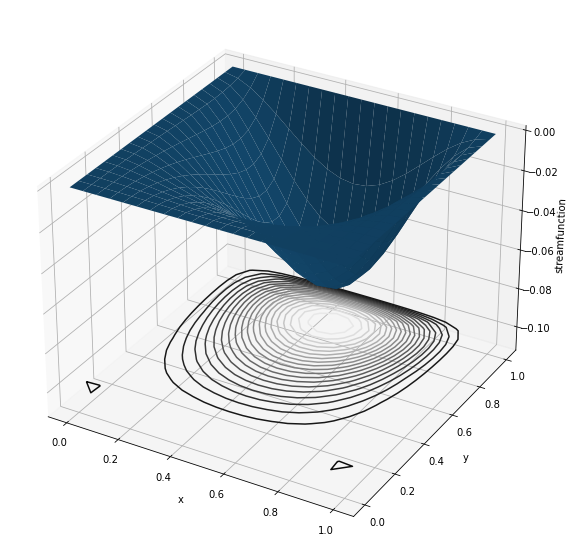

In [13]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [14]:
def find_min(z):
    return np.unravel_index(z.argmin(), z.shape)

In [15]:
# Min location
min_location = find_min(psi)
min_location, (x_grid[min_location], y_grid[min_location]), psi[min_location]

((10, 16), (0.5, 0.8), -0.08010118707181207)

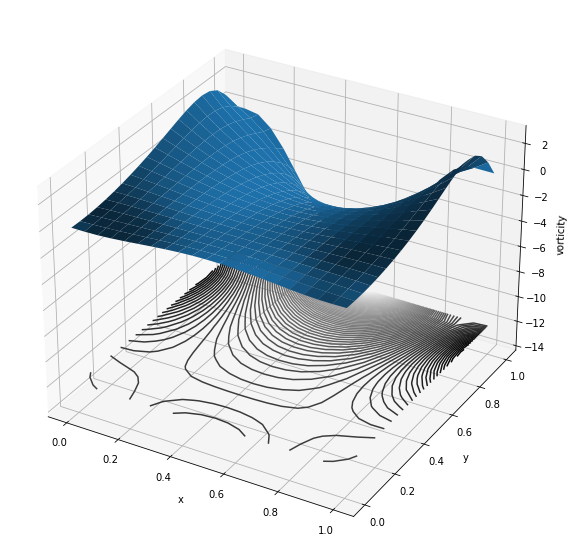

In [16]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

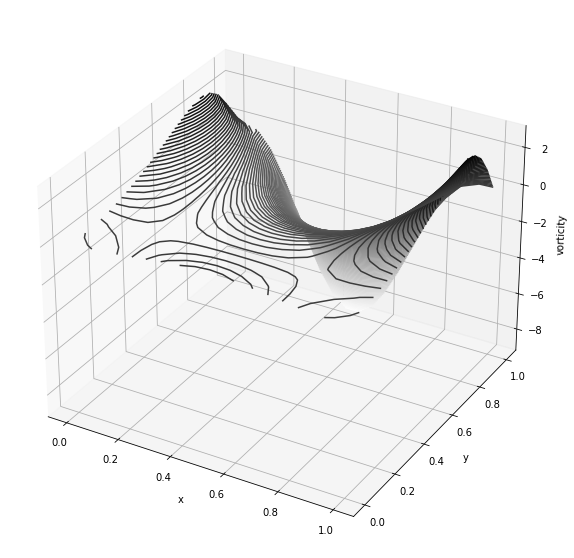

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

ax.contour3D(x_grid, y_grid, w, levels=145, cmap="binary")
ax.set(
    xlabel="x", ylabel="y", zlabel="vorticity",
)

plt.show()

In [18]:
# Min location
min_location = find_min(w)
min_location, (x_grid[min_location], y_grid[min_location]), w[min_location]

((10, 20), (0.5, 1.0), -8.954402809833521)

## Calculating u at middle

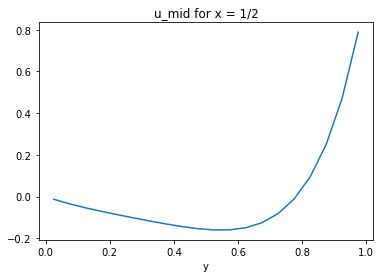

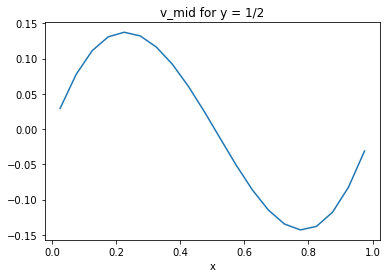

In [19]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = nx // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

## Calculating force

In [20]:
def calculate_force(psi, ny, h):
    # 1st order: (p[i,ny] - 2*p[i,ny-1] + p[i,ny-2])/h;
    # 2nd order:(2*p[i,ny] - 5*p[i,ny-1] + 4*p[i,ny-2] -p[i,ny-3])/h;
    
    return np.sum(
        2 * psi[1:nx - 1, ny - 1] -
        5 * psi[1:nx - 1, ny - 2] +
        4 * psi[1:nx - 1, ny - 3] -
        psi[1:nx - 1, ny - 4]
    ) / h

In [21]:
calculate_force(psi, ny=ny, h=h)

3.8360158609756545

# Calculating the flow

## Newton

In [22]:
%%time

N = 40
Re = 620
Re = 10 # i.e. mu = 0.1

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = newton_solver(N=N, Re=Re)

CPU times: user 3.36 s, sys: 105 ms, total: 3.47 s
Wall time: 9.19 s


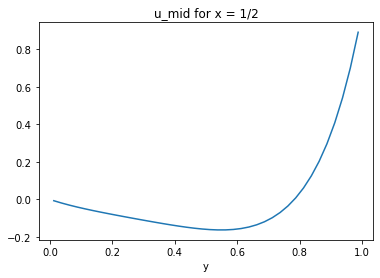

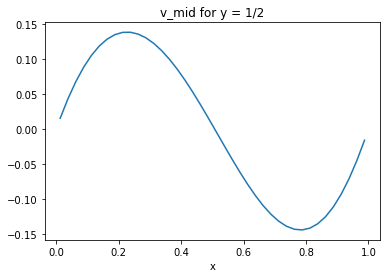

In [23]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = ny // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

In [24]:
def calculate_velocity(psi, h):
    nx = psi.shape[0]
    print(nx)
    
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    
    u[1:-1, 1:-1] = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * h)
    v[1:-1, 1:-1] = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * h)
    
    u[1:-1, -1] = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2
    
    return u, v 

41
(41, 41) (41, 41)


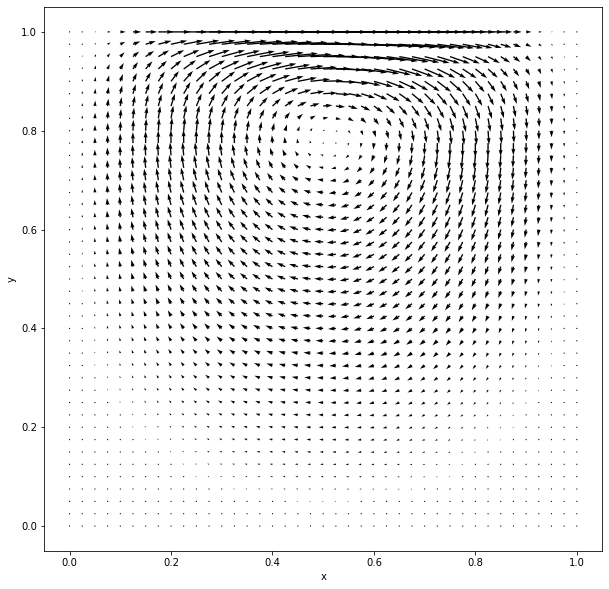

In [25]:
u, v = calculate_velocity(psi=psi, h=h)

print(u.shape, v.shape)
# print(u, v)

assert np.allclose(u[:, -1], np.sin(np.pi * np.arange(psi.shape[0]) * h) ** 2)
assert np.all(u[0, :] == 0)
assert np.all(u[:, 0] == 0)
assert np.all(u[-1, :] == 0)

assert np.all(v[0, :] == 0)
assert np.all(v[:, 0] == 0)
assert np.all(v[-1, :] == 0)
assert np.all(v[:, -1] == 0)

plt.figure(figsize=(10, 10))

# plt.scatter(x_grid, y_grid, s=5)
plt.quiver(x_grid, y_grid, u, v)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [26]:
xyuv = np.vstack([
    x_grid.flatten(), y_grid.flatten(), u.flatten(), v.flatten(),
]).T
print(xyuv.shape)

# np.savetxt('data/vorticity/flow_field.txt', xyuv, delimiter=' ', fmt=['%.2f', '%.18f'])
np.savetxt('data/vorticity/flow_field.txt', xyuv, delimiter=' ', fmt=['%.8f', '%.8f', '%.18f', '%.18f'])

(1681, 4)


## Evolution

In [32]:
%%time

# Stable

dpic = 0.5

N = 40
Re = 10 # i.e. mu = 0.1

tfinal = 3.0

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, omega_mid = solve(N=N, Re=Re, tfinal=tfinal, print_every=dpic)

t=0.50000; w(0.5, 0.5)=-0.5318425795976055
t=1.00000; w(0.5, 0.5)=-0.6392078531937394
t=1.50000; w(0.5, 0.5)=-0.6470209335147183
t=2.00000; w(0.5, 0.5)=-0.6475875194638533
t=2.50000; w(0.5, 0.5)=-0.6476286124379776
t=3.00000; w(0.5, 0.5)=-0.6476315928957449
CPU times: user 34.9 s, sys: 72.3 ms, total: 35 s
Wall time: 1min 33s


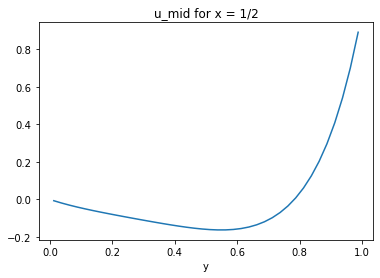

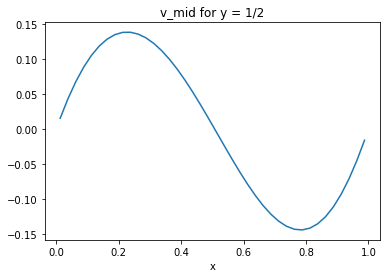

In [33]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = ny // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

41
(41, 41) (41, 41)


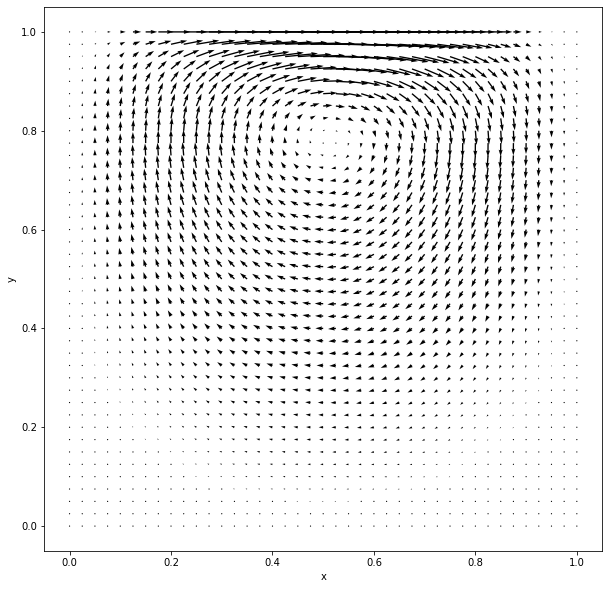

In [34]:
u, v = calculate_velocity(psi=psi, h=h)

print(u.shape, v.shape)
# print(u, v)

assert np.allclose(u[:, -1], np.sin(np.pi * np.arange(psi.shape[0]) * h) ** 2)
assert np.all(u[0, :] == 0)
assert np.all(u[:, 0] == 0)
assert np.all(u[-1, :] == 0)

assert np.all(v[0, :] == 0)
assert np.all(v[:, 0] == 0)
assert np.all(v[-1, :] == 0)
assert np.all(v[:, -1] == 0)

plt.figure(figsize=(10, 10))

# plt.scatter(x_grid, y_grid, s=5)
plt.quiver(x_grid, y_grid, u, v)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Vorticity vs h

10
12
14
16
18
20
24
28
[-0.63870549 -0.63886412 -0.63938514 -0.63906672 -0.63912118 -0.63915657
 -0.63934241 -0.63931814]


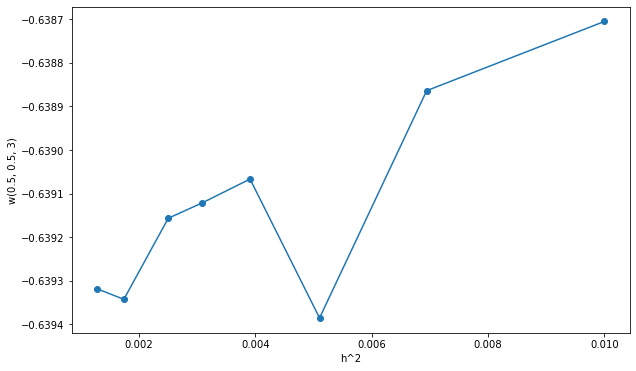

CPU times: user 6.65 s, sys: 33.3 ms, total: 6.68 s
Wall time: 17.9 s


In [53]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 1.0

plt.figure(figsize=(10, 6))

N_values = np.array([10, 12, 14, 16, 18, 20, 24, 28])
values = np.zeros(len(N_values))
for i, N in enumerate(N_values):
    print(N)
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    mid_idx = (N + 1) // 2
    values[i] = w[mid_idx, mid_idx]

print(values)
plt.plot(1 / N_values**2, values, "-o")    
plt.xlabel("h^2");
plt.ylabel("w(0.5, 0.5, 3)")

plt.show()

10
12
14
16
18
20
24
28
[-0.64493273 -0.64559767 -0.64605744 -0.64631623 -0.6465114  -0.64664766
 -0.64682684 -0.64691721]


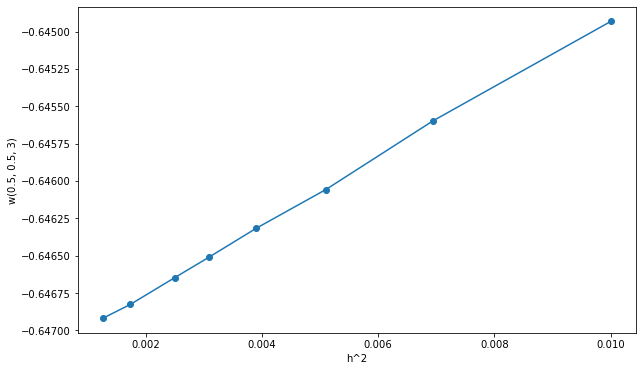

CPU times: user 9.84 s, sys: 45.5 ms, total: 9.89 s
Wall time: 26.4 s


In [54]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 1.5

plt.figure(figsize=(10, 6))

N_values = np.array([10, 12, 14, 16, 18, 20, 24, 28])
values = np.zeros(len(N_values))
for i, N in enumerate(N_values):
    print(N)
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    mid_idx = (N + 1) // 2
    values[i] = w[mid_idx, mid_idx]

print(values)
plt.plot(1 / N_values**2, values, "-o")    
plt.xlabel("h^2");
plt.ylabel("w(0.5, 0.5, 3)")

plt.show()

10
12
14
16
18
20
24
28
[-0.64534388 -0.64605762 -0.64652197 -0.64682689 -0.64703601 -0.64718228
 -0.64736461 -0.64746535]


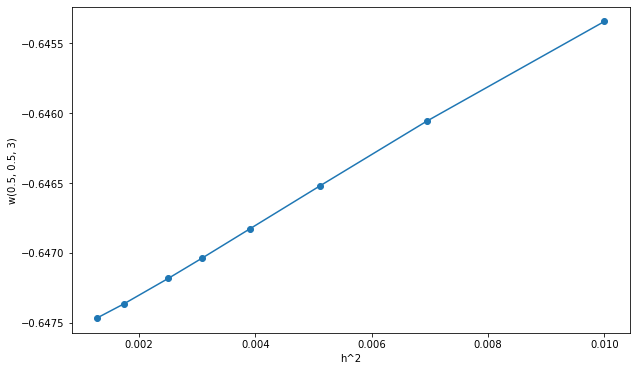

CPU times: user 13.1 s, sys: 38.3 ms, total: 13.1 s
Wall time: 35 s


In [51]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 2.0

plt.figure(figsize=(10, 6))

N_values = np.array([10, 12, 14, 16, 18, 20, 24, 28])
values = np.zeros(len(N_values))
for i, N in enumerate(N_values):
    print(N)
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    mid_idx = (N + 1) // 2
    values[i] = w[mid_idx, mid_idx]

print(values)
plt.plot(1 / N_values**2, values, "-o")    
plt.xlabel("h^2");
plt.ylabel("w(0.5, 0.5, 3)")

plt.show()

10
12
14
16
18
20
24
28
[-0.64537283 -0.64609119 -0.64655657 -0.6468654  -0.64707591 -0.64722317
 -0.64740603 -0.64750775]


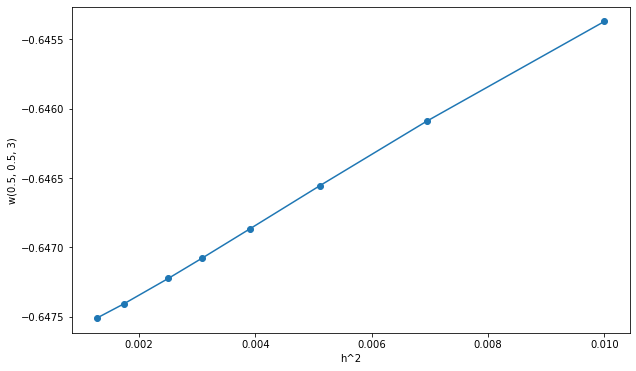

CPU times: user 16.2 s, sys: 38.4 ms, total: 16.3 s
Wall time: 16.5 s


In [55]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

plt.figure(figsize=(10, 6))

N_values = np.array([10, 12, 14, 16, 18, 20, 24, 28])
values = np.zeros(len(N_values))
for i, N in enumerate(N_values):
    print(N)
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    mid_idx = (N + 1) // 2
    values[i] = w[mid_idx, mid_idx]

print(values)
plt.plot(1 / N_values**2, values, "-o")    
plt.xlabel("h^2");
plt.ylabel("w(0.5, 0.5, 3)")

plt.show()

In [57]:
# xy = np.vstack([1 / N_values**2, values]).T
# print(xy.shape)

# np.savetxt('data/vorticity/omega_vs_h.txt', xy, delimiter=' ', fmt=['%.18f', '%.18f'])

(8, 2)
